/Users/chenyk/aaspip.pyseistr/pyseistr/plot.py:127: UserWarning: The following kwargs were not used by contour: 'barlabel'
  zdir='z', offset=0, **kw
/Users/chenyk/aaspip.pyseistr/pyseistr/plot.py:132: UserWarning: The following kwargs were not used by contour: 'barlabel'
  zdir='y', offset=Y.min(), **kw
/Users/chenyk/aaspip.pyseistr/pyseistr/plot.py:137: UserWarning: The following kwargs were not used by contour: 'barlabel'
  zdir='x', offset=X.max(), **kw


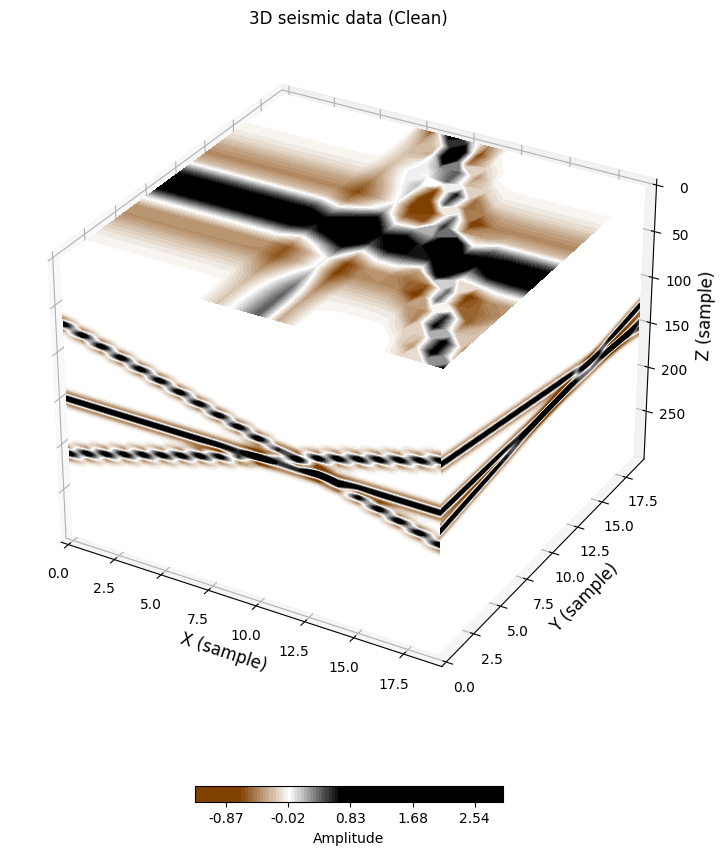

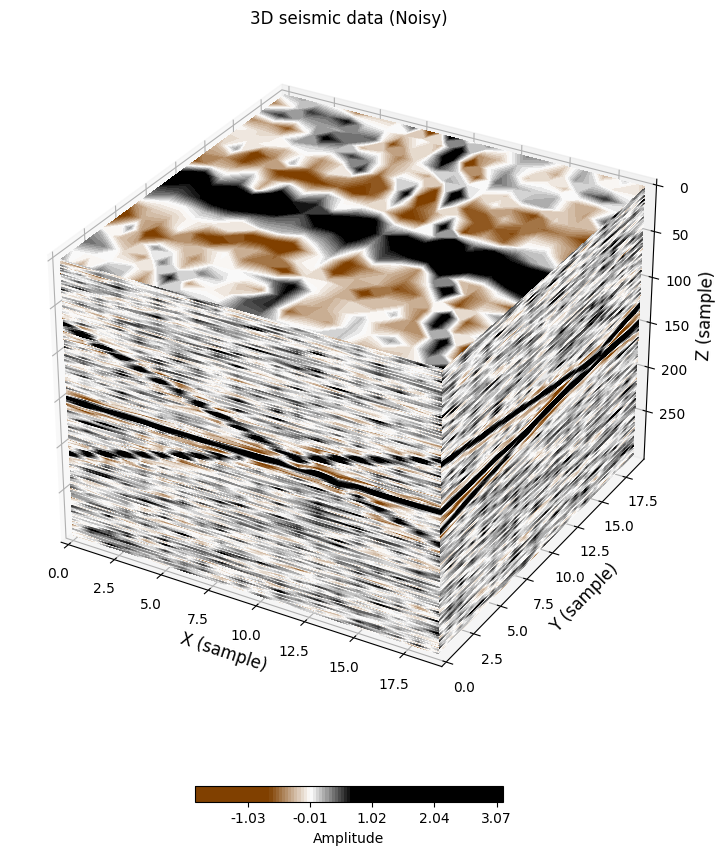

In [1]:
# Prepared On Jan 1, 2025 by Yangkang Chen, UT-Austin
#
# As a reproduced example for two papers
# [1] Chen, Y., Zhang, M., Bai, M., & Chen, W. (2019). Improving the signal‐to‐noise ratio of seismological datasets by unsupervised machine learning. Seismological Research Letters, 90(4), 1552-1564.
# [2] Saad, O. M., & Chen, Y. (2021). A fully unsupervised and highly generalized deep learning approach for random noise suppression. Geophysical Prospecting, 69(4), 709-726.
#
# NOTE: both examples are unsupervised learning approaches. 
# Please use the latest pyseistr package:
# https://github.com/aaspip/pyseistr
#
# Environment: 
# CPU machine
# conda create -n uml python=3.11.7
# conda activate uml
# conda install ipython notebook
# pip install matplotlib==3.8.0 tensorflow==2.14.0 scikit-learn==1.2.2 seaborn==0.13.2 
# 
# GPU machine
# conda create -n uml python=3.10.14
# conda activate uml
# conda install ipython notebook
# pip install matplotlib==3.8.0 tensorflow==2.11.0 scikit-learn==1.2.2 seaborn==0.13.2 
# conda install -c anaconda cudnn==8.2.1
#
#
#generate data
import numpy as np
from pyseistr import genplane3d,plot3d
import matplotlib.pyplot as plt
data,noisy=genplane3d(noise=True,seed=202425,var=0.1);

dz=1;dx=1;dy=1;
[nz,nx,ny]=data.shape;
plot3d(data,vmin=-1,vmax=1,figsize=(14,10),z=np.arange(nz)*dz,x=np.arange(nx)*dx,y=np.arange(ny)*dy,barlabel='Amplitude',showf=False,close=False)
plt.gca().set_xlabel("X (sample)",fontsize='large', fontweight='normal')
plt.gca().set_ylabel("Y (sample)",fontsize='large', fontweight='normal')
plt.gca().set_zlabel("Z (sample)",fontsize='large', fontweight='normal')
plt.title('3D seismic data (Clean)')
plt.savefig(fname='data3d-clean.png',format='png',dpi=300)
plt.show()

plot3d(noisy,vmin=-1,vmax=1,figsize=(14,10),z=np.arange(nz)*dz,x=np.arange(nx)*dx,y=np.arange(ny)*dy,barlabel='Amplitude',showf=False,close=False)
plt.gca().set_xlabel("X (sample)",fontsize='large', fontweight='normal')
plt.gca().set_ylabel("Y (sample)",fontsize='large', fontweight='normal')
plt.gca().set_zlabel("Z (sample)",fontsize='large', fontweight='normal')
plt.title('3D seismic data (Noisy)')
plt.savefig(fname='data3d-noisy.png',format='png',dpi=300)
plt.show()

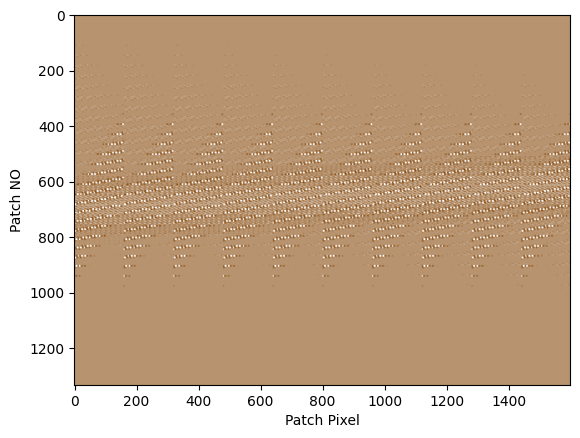

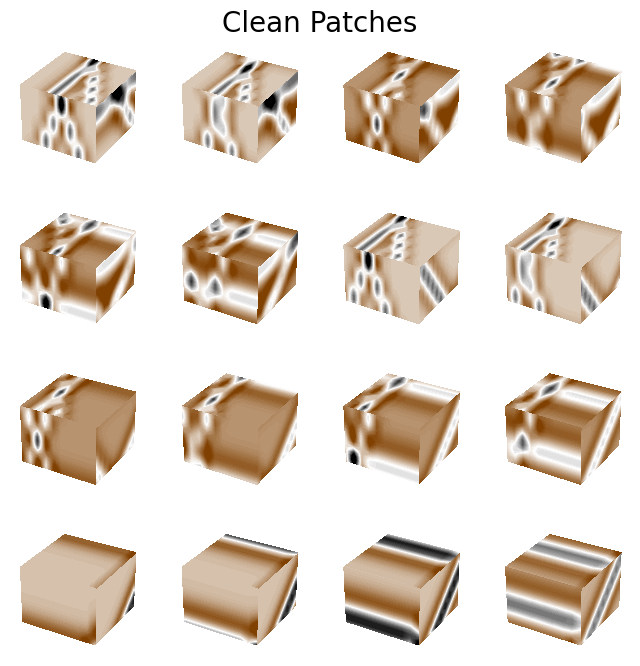

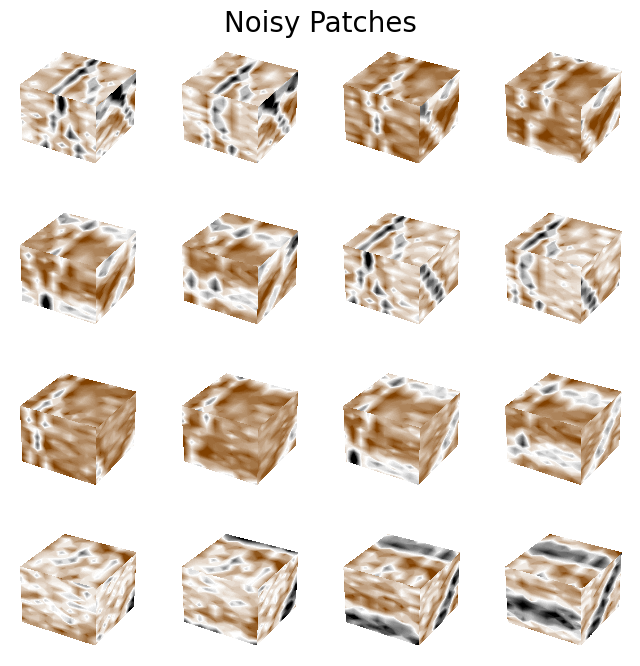

In [2]:
from pyseistr import patch3d,patch3d_inv,snr
X=patch3d(data,l1=16,l2=10,l3=10,s1=8,s2=2,s3=2);
Xnoisy=patch3d(noisy,l1=16,l2=10,l3=10,s1=8,s2=2,s3=2);

from pyseistr import cseis
plt.imshow(X,aspect='auto',cmap=cseis());plt.ylabel('Patch NO');plt.xlabel('Patch Pixel');plt.show()

# plot clean patches
plt.figure(figsize=(8,8))
plt.text(0.35,1.02,'Clean patches',size=20,weight='normal')
for ii in range(16):
            ax=plt.subplot(4,4,ii+1,projection='3d')
            plot3d(X[600+ii,:].reshape(16,10,10,order='F'),ifnewfig=False,showf=False,close=False)
            plt.gca().axis('off')
ax = plt.gcf().add_subplot(111, aspect='auto');plt.gca().axis('off');plt.title("Clean Patches",size=20)
plt.show()

# plot noisy patches
plt.figure(figsize=(8,8))
for ii in range(16):
            ax=plt.subplot(4,4,ii+1,projection='3d')
            plot3d(Xnoisy[600+ii,:].reshape(16,10,10,order='F'),ifnewfig=False,showf=False,close=False)
            plt.gca().axis('off')
ax = plt.gcf().add_subplot(111, aspect='auto');plt.gca().axis('off');plt.title("Noisy Patches",size=20)
plt.show()


In [3]:
from keras import layers
from keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Dropout, concatenate, LeakyReLU,BatchNormalization
# from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# The following architecture was used in 
# Chen, Y., Zhang, M., Bai, M., & Chen, W. (2019). Improving the signal‐to‐noise ratio of seismological datasets by unsupervised machine learning. Seismological Research Letters, 90(4), 1552-1564.

input = layers.Input(shape=(1600,))                            #or from tensorflow.keras.layers import Input, Dense
x = layers.Dense(128, activation="relu", name="layer1")(input)  
x = layers.Dense(1600, activation="linear", name="layer2")(x)  

# Autoencoder
autoencoder = Model(input,x)
autoencoder.summary()

# Compile
autoencoder.compile(optimizer="adam", loss='mse')


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1600)]            0         
                                                                 
 layer1 (Dense)              (None, 128)               204928    
                                                                 
 layer2 (Dense)              (None, 1600)              206400    
                                                                 
Total params: 411,328
Trainable params: 411,328
Non-trainable params: 0
_________________________________________________________________


2025-01-01 14:56:06.288854: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import datetime
today=datetime.date.today()
weightname='best_model_%s.weights.h5'%str(today)


checkpoint = ModelCheckpoint(filepath=weightname,monitor='val_loss',mode = 'min',verbose=1,save_weights_only=True,save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=0.1,cooldown=0,patience=50,min_lr=0.5e-6,monitor='val_loss',mode = 'min',verbose= 1)

autoencoder.fit(Xnoisy,Xnoisy, batch_size=128, verbose=1,epochs=20,callbacks=[checkpoint,lr_reducer],validation_split=0.2)


Epoch 1/20
1/9 [==>...........................] - ETA: 3s - loss: 0.1734
Epoch 1: val_loss improved from inf to 0.09010, saving model to best_model_2025-01-01.weights.h5
9/9 [==============================] - 1s 21ms/step - loss: 0.1606 - val_loss: 0.0901 - lr: 0.0010
Epoch 2/20
1/9 [==>...........................] - ETA: 0s - loss: 0.1546
Epoch 2: val_loss improved from 0.09010 to 0.08926, saving model to best_model_2025-01-01.weights.h5
9/9 [==============================] - 0s 9ms/step - loss: 0.1467 - val_loss: 0.0893 - lr: 0.0010
Epoch 3/20
1/9 [==>...........................] - ETA: 0s - loss: 0.1241
Epoch 3: val_loss improved from 0.08926 to 0.08835, saving model to best_model_2025-01-01.weights.h5
9/9 [==============================] - 0s 8ms/step - loss: 0.1341 - val_loss: 0.0884 - lr: 0.0010
Epoch 4/20
1/9 [==>...........................] - ETA: 0s - loss: 0.1241
Epoch 4: val_loss improved from 0.08835 to 0.08779, saving model to best_model_2025-01-01.weights.h5
9/9 [========

In [5]:
Xout = autoencoder.predict(Xnoisy)

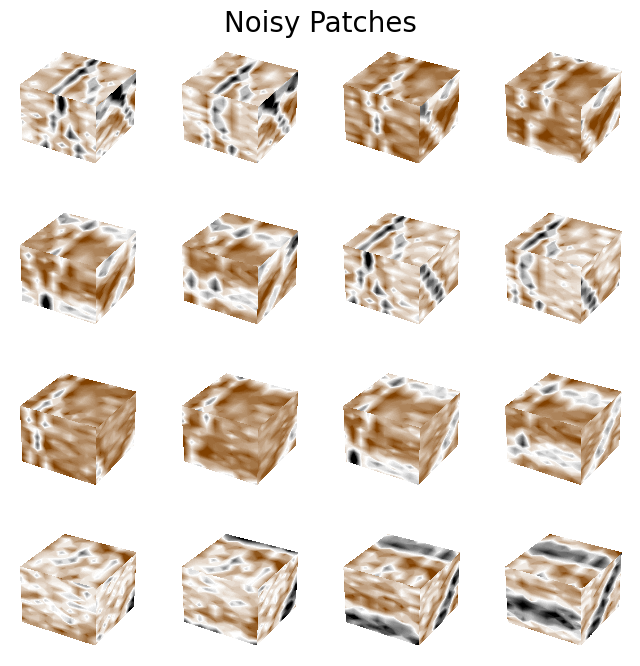

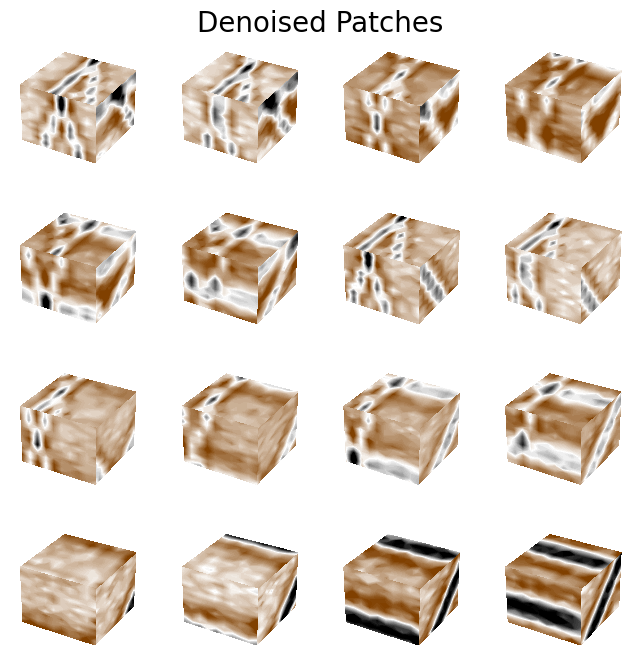

In [6]:
# plt.figure(figsize=(8,8))
# for ii in range(64):
#             ax=plt.subplot(8,8,ii+1)
#             plt.imshow(Xnoisy[3200+ii,:].reshape(16,16,order='F'),cmap=cseis(),clim=(-0.5,0.5),aspect='auto');
#             plt.setp(ax.get_xticklabels(), visible=False);plt.setp(ax.get_yticklabels(), visible=False);
# plt.show()

# plt.figure(figsize=(8,8))
# for ii in range(64):
#             ax=plt.subplot(8,8,ii+1)
#             plt.imshow(Xout[3200+ii,:].reshape(16,16,order='F'),cmap=cseis(),clim=(-0.5,0.5),aspect='auto');
#             plt.setp(ax.get_xticklabels(), visible=False);plt.setp(ax.get_yticklabels(), visible=False);
# plt.show()

plt.figure(figsize=(8,8))
for ii in range(16):
            ax=plt.subplot(4,4,ii+1,projection='3d')
            plot3d(Xnoisy[600+ii,:].reshape(16,10,10,order='F'),ifnewfig=False,showf=False,close=False)
            plt.gca().axis('off')
ax = plt.gcf().add_subplot(111, aspect='auto');plt.gca().axis('off');plt.title("Noisy Patches",size=20)
plt.show()

plt.figure(figsize=(8,8))
for ii in range(16):
            ax=plt.subplot(4,4,ii+1,projection='3d')
            plot3d(Xout[600+ii,:].reshape(16,10,10,order='F'),ifnewfig=False,showf=False,close=False)
            plt.gca().axis('off')
ax = plt.gcf().add_subplot(111, aspect='auto');plt.gca().axis('off');plt.title("Denoised Patches",size=20)
plt.show()

/Users/chenyk/aaspip.pyseistr/pyseistr/plot.py:127: UserWarning: The following kwargs were not used by contour: 'barlabel'
  zdir='z', offset=0, **kw
/Users/chenyk/aaspip.pyseistr/pyseistr/plot.py:132: UserWarning: The following kwargs were not used by contour: 'barlabel'
  zdir='y', offset=Y.min(), **kw
/Users/chenyk/aaspip.pyseistr/pyseistr/plot.py:137: UserWarning: The following kwargs were not used by contour: 'barlabel'
  zdir='x', offset=X.max(), **kw


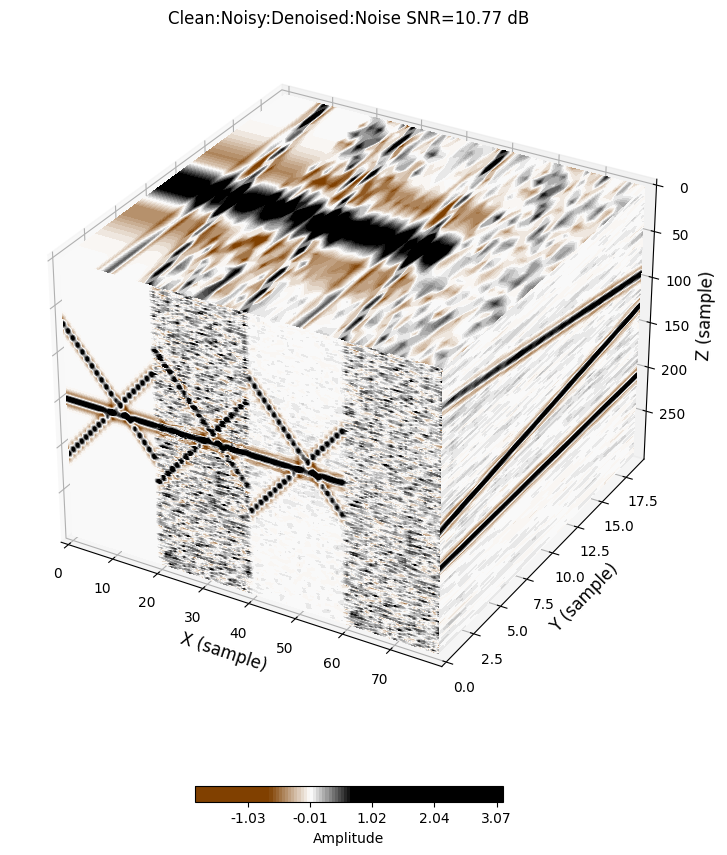

In [7]:
# reconstruct data
denoised=patch3d_inv(Xout,nz,nx,ny,l1=16,l2=10,l3=10,s1=8,s2=2,s3=2);

plot3d(np.concatenate([data,noisy,denoised,noisy-denoised],axis=1),vmin=-1,vmax=1,figsize=(14,10),z=np.arange(nz)*dz,x=np.arange(nx*4)*dx,y=np.arange(ny)*dy,barlabel='Amplitude',showf=False,close=False)
plt.gca().set_xlabel("X (sample)",fontsize='large', fontweight='normal')
plt.gca().set_ylabel("Y (sample)",fontsize='large', fontweight='normal')
plt.gca().set_zlabel("Z (sample)",fontsize='large', fontweight='normal')
plt.title('Clean:Noisy:Denoised:Noise SNR={SNR:.2f} dB'.format(SNR=snr(data,denoised,mode=2)))
plt.savefig(fname='data3d-denoised.png',format='png',dpi=300)
plt.show()

In [8]:
## Different implementations

from tensorflow.keras.layers import Input, Dense, Dropout, concatenate, LeakyReLU,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# The following architecture was used in 
# Saad, O. M., & Chen, Y. (2021). A fully unsupervised and highly generalized deep learning approach for random noise suppression. Geophysical Prospecting, 69(4), 709-726.

## In comparison with a simpler and textbook example
# input = layers.Input(shape=(256,))                            
# x = layers.Dense(64, activation="relu", name="layer1")(input)  
# x = layers.Dense(256, activation="linear", name="layer2")(x)  

input = Input(shape=(1600,))

encoded02 = Dense(800,  activation='relu')(input)

encoded01 = Dense(400,  activation='relu')(encoded02)

encoded1 = Dense(128,  activation='relu')(encoded01)
#encoded1 = BatchNormalization()(encoded1)
#encoded1 = Dropout(0.01)(encoded1)

encoded2 = Dense(64,  activation='relu')(encoded1)
#encoded2 = BatchNormalization()(encoded2)
#encoded2 = Dropout(0.01)(encoded2)

encoded3 = Dense(32,  activation='relu' )(encoded2)
#encoded3 = BatchNormalization()(encoded3)
#encoded3 = Dropout(0.01)(encoded3)

encoded4 = Dense(16,  activation='relu' )(encoded3)
#encoded3 = BatchNormalization()(encoded3)
#encoded4 = Dropout(0.01)(encoded4)

encoded5 = Dense(8,  activation='relu' )(encoded4)
#encoded5 = BatchNormalization()(encoded5)
#encoded5 = Dropout(0.01)(encoded5)

encoded6 = Dense(4,  activation='relu' )(encoded5)
#encoded6 = BatchNormalization()(encoded6)
#encoded6 = Dropout(0.01)(encoded6)

# Decoder

decoded1aa = Dense(4,  activation='relu' )(encoded6)
#decoded1aa = BatchNormalization()(decoded1aa)
decoded1aa = concatenate([decoded1aa,encoded6])
#decoded1aa = Dropout(0.01)(decoded1aa)


decoded1a = Dense(8,  activation='relu' )(decoded1aa)
#decoded1a = BatchNormalization()(decoded1a)
decoded1a = concatenate([decoded1a,encoded5])
#decoded1a = Dropout(0.01)(decoded1a)

decoded1 = Dense(16,  activation='relu' )(decoded1a)
#decoded1 = BatchNormalization()(decoded1)
decoded1 = concatenate([decoded1,encoded4])
#decoded1 = Dropout(0.01)(decoded1)

decoded2 = Dense(32,  activation='relu')(decoded1)
#decoded2 = BatchNormalization()(decoded2)
decoded2 = concatenate([decoded2,encoded3])
#decoded2 = Dropout(0.01)(decoded2)

decoded3 = Dense(64,  activation='relu' )(decoded2)
#decoded3 = BatchNormalization()(decoded3)
decoded3 = concatenate([decoded3,encoded2])
#decoded3 = Dropout(0.01)(decoded3)

decoded4 = Dense(128,  activation='relu' )(decoded3)
#decoded4 = BatchNormalization()(decoded4)
decoded4 = concatenate([decoded4,encoded1])
#decoded4 = Dropout(0.01)(decoded4)

decoded401 = Dense(400,  activation='relu' )(decoded4)
decoded401 = concatenate([decoded401,encoded01])

decoded402 = Dense(800,  activation='relu' )(decoded401)
decoded402 = concatenate([decoded402,encoded02])

#decoded = Flatten()(decoded3)
x = Dense(1600, activation='linear')(decoded402)


# Autoencoder
autoencoder = Model(input,x)
autoencoder.summary()

# Compile
autoencoder.compile(optimizer="adam", loss='mse')


import datetime
today=datetime.date.today()
weightname='best_model_PATCHUNET_%s.weights.h5'%str(today)

earlystop  = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
checkpoint = ModelCheckpoint(filepath=weightname,monitor='val_loss',mode = 'min',verbose=1,save_weights_only=True,save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=0.1,cooldown=0,patience=50,min_lr=0.5e-6,monitor='val_loss',mode = 'min',verbose= 1)

autoencoder.fit(Xnoisy,Xnoisy, batch_size=128, verbose=1,epochs=4,callbacks=[earlystop,checkpoint,lr_reducer],validation_split=0.2)



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1600)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 800)          1280800     ['input_2[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 400)          320400      ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 128)          51328       ['dense_1[0][0]']                
                                                                                            

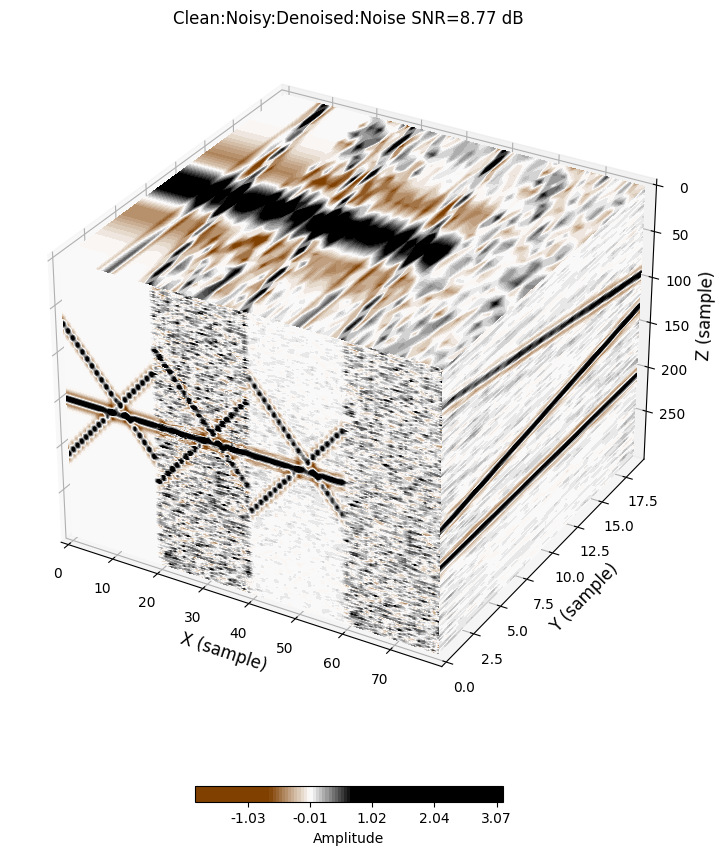

In [9]:
Xout = autoencoder.predict(Xnoisy)

# reconstruct data
denoised2=patch3d_inv(Xout,nz,nx,ny,l1=16,l2=10,l3=10,s1=8,s2=2,s3=2);

plot3d(np.concatenate([data,noisy,denoised2,noisy-denoised2],axis=1),vmin=-1,vmax=1,figsize=(14,10),z=np.arange(nz)*dz,x=np.arange(nx*4)*dx,y=np.arange(ny)*dy,barlabel='Amplitude',showf=False,close=False)
plt.gca().set_xlabel("X (sample)",fontsize='large', fontweight='normal')
plt.gca().set_ylabel("Y (sample)",fontsize='large', fontweight='normal')
plt.gca().set_zlabel("Z (sample)",fontsize='large', fontweight='normal')
plt.title('Clean:Noisy:Denoised:Noise SNR={SNR:.2f} dB'.format(SNR=snr(data,denoised2,mode=2)))
plt.savefig(fname='data3d-denoised2.png',format='png',dpi=300)
plt.show()


## NOTE:
##
## Why a much more complicated network architecture does not bring as much benefit as we want
##
## Maybe because this problem is not complicated enough that needs a complicated architecture
## e.g., the data structure is complicated at all (here it is simply linear events)
## So, always be careful about designing the "complicated" network architecture that best suits your data